In [3]:
import os
import glob
import librosa
import numpy as np
import noisereduce as nr
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed

# Chirp extraction

In [ ]:
def extract_early_highfreq_chirp(input_path, output_path, sr=22050, band=(6000, 10000),
                                  energy_thresh=0.1, max_duration=1.2,
                                  pre_padding=1.0, post_padding=2.0):
    # y, sr = librosa.load(input_path, sr=sr)
    y, sr = librosa.load(input_path, sr=sr, duration=8.0)
    hop_len = 256
    n_fft = 1024

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_len))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    time_bins = S.shape[1]

    mask = (freqs >= band[0]) & (freqs <= band[1])
    high_freq_energy = S[mask].mean(axis=0)
    norm_energy = high_freq_energy / np.max(high_freq_energy)
    active = norm_energy > energy_thresh

    from scipy.ndimage import label
    labeled, num = label(active)
    candidates = []

    for i in range(1, num + 1):
        idx = np.where(labeled == i)[0]
        duration = len(idx) * hop_len / sr
        start = idx[0] * hop_len / sr
        if duration <= max_duration:
            candidates.append((start, duration))

    if not candidates:
        print("no chirp found.....")
        return None

    candidates.sort(key=lambda x: x[0])
    start_time, duration = candidates[0]

    # NEW: Custom padding
    clip_start = max(0, start_time - pre_padding)
    clip_end = min(len(y)/sr, start_time + duration + post_padding)

    y_clip = y[int(clip_start * sr): int(clip_end * sr)]
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sf.write(output_path, y_clip, sr)
    print(f"Saved chirp with padding: {output_path} ({clip_end - clip_start:.2f}s)")
    return output_path

def batch_extract_chirps(folder_path, max_workers=4,
                         pre_padding=1.0, post_padding=1.0,
                         energy_thresh=0.08, max_duration=1.2):
    
    ogg_files = glob.glob(os.path.join(folder_path, "*.ogg"))
    output_dir = os.path.join(folder_path, "processed")
    os.makedirs(output_dir, exist_ok=True)

    print(f"Processing {len(ogg_files)} files...")

    def process_file(filepath):
        filename = os.path.splitext(os.path.basename(filepath))[0]
        output_path = os.path.join(output_dir, f"{filename}_chirp.wav")
        return extract_early_highfreq_chirp(
            input_path=filepath,
            output_path=output_path,
            pre_padding=pre_padding,
            post_padding=post_padding,
            energy_thresh=energy_thresh,
            max_duration=max_duration
        )

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_file, f) for f in ogg_files]
        for future in as_completed(futures):
            future.result()

    print("All chirp extractions complete")


input_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/1139490"
output_file = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/1192948/processed/CSA36358_birdonly.wav"

batch_extract_chirps(
    folder_path=input_folder,
    max_workers=max(1, os.cpu_count() - 1),
    pre_padding=1.0,
    post_padding=2.0,
    energy_thresh=0.08,     # sensitivity to chirp
    max_duration=1.2,       # ignore human voice segments
)


## Use This One!

In [3]:
import os
import librosa
import numpy as np
import soundfile as sf
from scipy.stats import zscore
from concurrent.futures import ThreadPoolExecutor, as_completed
import glob
import progressbar


def extract_faint_bird_chirp(input_path, output_path, sr=22050,
                              band=(5000, 10000),
                              max_duration=1.2,
                              pre_padding=0.5,
                              post_padding=1.0,
                              max_audio_duration=10.0):
    try:
        y, sr = librosa.load(input_path, sr=sr, duration=max_audio_duration)
        hop_len = 256
        n_fft = 1024

        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_len))
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        bird_mask = (freqs >= band[0]) & (freqs <= band[1])
        high_freq_energy = S[bird_mask].mean(axis=0)

        z_energy = zscore(high_freq_energy)
        peak_frame = np.argmax(z_energy)

        center_sec = (peak_frame * hop_len) / sr
        clip_start = max(0, center_sec - pre_padding)
        clip_end = min(len(y) / sr, center_sec + post_padding)

        if clip_end - clip_start < 0.5:
            clip_end = min(len(y) / sr, clip_start + 1.5)

        start_sample = int(clip_start * sr)
        end_sample = int(clip_end * sr)
        y_clip = y[start_sample:end_sample]

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        sf.write(output_path, y_clip, sr)
        return True  # success

    except Exception as e:
        return f"{input_path} — {e}"  # error message


def batch_extract_faint_chirps(input_base, output_base, max_workers=4,
                                pre_padding=0.5,
                                post_padding=1.0,
                                band=(5000, 10000),
                                max_audio_duration=10.0):
    ogg_files = glob.glob(os.path.join(input_base, '**', '*.ogg'), recursive=True)
    print(f"Found {len(ogg_files)} .ogg files in {input_base}")

    failed_files = []

    def process_file(input_path):
        rel_path = os.path.relpath(input_path, input_base)
        id_folder = os.path.dirname(rel_path)
        filename_wo_ext = os.path.splitext(os.path.basename(input_path))[0]
        output_folder = os.path.join(output_base, id_folder)
        output_path = os.path.join(output_folder, f"{filename_wo_ext}_chirp.wav")

        result = extract_faint_bird_chirp(
            input_path=input_path,
            output_path=output_path,
            pre_padding=pre_padding,
            post_padding=post_padding,
            band=band,
            max_audio_duration=max_audio_duration
        )
        return result

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_file, f): f for f in ogg_files}
        with progressbar.ProgressBar(max_value=len(futures), redirect_stdout=True) as bar:
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not True:
                    failed_files.append(result)
                bar.update(i + 1)

    print("\n chirp extractions complete")
    if failed_files:
        print(f"\n {len(failed_files)} files failed to process:")
        for fail in failed_files:
            print("  -", fail)
    else:
        print("\n all files processed successfully!")



input_base = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/download"
output_base = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"


batch_extract_faint_chirps(
    input_base=input_base,
    output_base=output_base,
    max_workers=max(1, os.cpu_count() - 1),
    pre_padding=1.0,
    post_padding=2.0,
    band=(5000, 10000),
    max_audio_duration=8.0
)


🛠️  Found 28564 .ogg files in C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/download


100% (28564 of 28564) |##################| Elapsed Time: 0:06:36 Time:  0:06:360332



✅ All chirp extractions complete.

🎉 All files processed successfully!


# Noise 

### Use this one!

### Median Filter Spectrogram
Applies a median filter across time-frequency bins, suppressing noise "speckles" while preserving harmonics (bird calls are harmonic-rich).

Pros: Very effective at removing transient noise and preserving bird chirps.
Cons: Might require tuning kernel size.

In [12]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
from scipy.ndimage import median_filter
from concurrent.futures import ThreadPoolExecutor, as_completed
import progressbar

def median_filter_denoise(input_path, output_path,
                           filter_size=(3, 5),  # (freq_bins, time_bins)
                           trim_db=30):
    try:
        
        y, sr = librosa.load(input_path, sr=None)

        # === STFT ===
        n_fft = 2048
        hop_length = 512
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        magnitude, phase = np.abs(D), np.angle(D)

        # === Median filter ===
        filtered_mag = median_filter(magnitude, size=filter_size)

        # === Reconstruct using filtered magnitude + original phase ===
        D_denoised = filtered_mag * np.exp(1j * phase)
        y_denoised = librosa.istft(D_denoised, hop_length=hop_length)

        # === Trim silent edges ===
        y_denoised, _ = librosa.effects.trim(y_denoised, top_db=trim_db)

        # === Save output ===
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        sf.write(output_path, y_denoised, sr)
        return True
    except Exception as e:
        return f"{input_path} — {e}"


def batch_median_filter_denoise(preprocessed_base, max_workers=4):
    chirp_files = glob.glob(os.path.join(preprocessed_base, '**', '*_chirp.wav'), recursive=True)
    print(f"Found {len(chirp_files)} chirp files for median filter denoising.")

    failed_files = []

    def process_file(chirp_path):
        output_path = chirp_path.replace('_chirp.wav', '_denoised_median_filter.wav')
        return median_filter_denoise(chirp_path, output_path)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_file, f): f for f in chirp_files}
        with progressbar.ProgressBar(max_value=len(futures), redirect_stdout=True) as bar:
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not True:
                    failed_files.append(result)
                bar.update(i + 1)

    print("\n median filter denoising complete.")
    if failed_files:
        print(f"\n❌ {len(failed_files)} failed:")
        for f in failed_files:
            print("  -", f)
    else:
        print("\n All files denoised successfully!")



preprocessed_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"

batch_median_filter_denoise(
    preprocessed_base=preprocessed_folder,
    max_workers=max(1, os.cpu_count() - 1)
)


🎧 Found 28564 chirp files for median filter denoising.


100% (28564 of 28564) |##################| Elapsed Time: 0:09:31 Time:  0:09:310446



✅ Median filter denoising complete.

🎉 All files denoised successfully!


### Spectral Subtraction Based on Envelope/Contour Shape
Tracks the shape of the frequency energy envelope and removes "non-chirp-like" blobs using heuristics:

1. Only keep frequency blobs that rise and fall quickly
2. Remove smeared horizontal or vertical noise streaks

In [13]:
import os
import numpy as np
import librosa
import soundfile as sf
from scipy.ndimage import gaussian_filter1d
from concurrent.futures import ThreadPoolExecutor, as_completed
import glob
import progressbar


def contour_based_spectral_denoise(input_path, output_path,
                                    band=(1000, 8000),
                                    smoothing_sigma=2,
                                    threshold_scale=0.5,
                                    trim_db=30):
    try:

        y, sr = librosa.load(input_path, sr=None)

        # === Compute STFT and focus on bird frequency band ===
        n_fft = 2048
        hop_length = 512
        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
        bird_mask = (freqs >= band[0]) & (freqs <= band[1])
        S_bird = S[bird_mask]

        # === Extract and smooth the temporal energy contour ===
        energy = np.sum(S_bird**2, axis=0)
        norm_energy = energy / np.max(energy)
        smoothed_energy = gaussian_filter1d(norm_energy, sigma=smoothing_sigma)

        # === Adaptive threshold based on contour shape ===
        adaptive_threshold = np.mean(smoothed_energy) + threshold_scale * np.std(smoothed_energy)
        time_mask = smoothed_energy > adaptive_threshold
        sample_mask = np.repeat(time_mask, hop_length)
        sample_mask = sample_mask[:len(y)]

        # === Apply mask to original signal ===
        y_denoised = y[:len(sample_mask)] * sample_mask

        # === Optional: Trim silent edges ===
        y_denoised, _ = librosa.effects.trim(y_denoised, top_db=trim_db)

        # === Save output ===
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        sf.write(output_path, y_denoised, sr)
        return True
    except Exception as e:
        return f"{input_path} — {e}"


def batch_contour_denoise(preprocessed_base, max_workers=4):
    chirp_files = glob.glob(os.path.join(preprocessed_base, '**', '*_chirp.wav'), recursive=True)
    print(f"Found {len(chirp_files)} chirp files for contour-based denoising.")

    failed_files = []

    def process_file(chirp_path):
        output_path = chirp_path.replace('_chirp.wav', '_denoised_spectral.wav')
        return contour_based_spectral_denoise(chirp_path, output_path)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_file, f): f for f in chirp_files}
        with progressbar.ProgressBar(max_value=len(futures), redirect_stdout=True) as bar:
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not True:
                    failed_files.append(result)
                bar.update(i + 1)

    print("\n Contour-based spectral denoising complete.")
    if failed_files:
        print(f"\n{len(failed_files)} failed:")
        for f in failed_files:
            print("  -", f)
    else:
        print("\n All files denoised successfully!")


preprocessed_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"

batch_contour_denoise(
    preprocessed_base=preprocessed_folder,
    max_workers=max(1, os.cpu_count() - 1)
)

🎧 Found 28564 chirp files for contour-based denoising.


100% (28564 of 28564) |##################| Elapsed Time: 0:04:44 Time:  0:04:440223



✅ Contour-based spectral denoising complete.

🎉 All files denoised successfully!


### HPSS not so good 

In [11]:
import os
import glob
import librosa
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed
import progressbar

def hpss_denoise(input_path, output_path):
    try:
        y, sr = librosa.load(input_path, sr=None)
        harmonic, _ = librosa.effects.hpss(y)
        sf.write(output_path, harmonic, sr)
        return True
    except Exception as e:
        return f"{input_path} — {e}"

def batch_hpss_denoise(preprocessed_base, max_workers=4):
    chirp_files = glob.glob(os.path.join(preprocessed_base, '**', '*_chirp.wav'), recursive=True)
    print(f"Found {len(chirp_files)} preprocessed chirp files to denoise using HPSS.")

    failed_files = []

    def process_file(chirp_path):
        denoised_path = chirp_path.replace("_chirp.wav", "_denoised_hpss.wav")
        return hpss_denoise(chirp_path, denoised_path)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_file, f): f for f in chirp_files}
        with progressbar.ProgressBar(max_value=len(futures), redirect_stdout=True) as bar:
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not True:
                    failed_files.append(result)
                bar.update(i + 1)

    print("\n HPSS denoising complete.")
    if failed_files:
        print(f"\n {len(failed_files)} files failed:")
        for f in failed_files:
            print("  -", f)
    else:
        print("\n All files denoised successfully!")


preprocessed_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"

batch_hpss_denoise(
    preprocessed_base=preprocessed_folder,
    max_workers=max(1, os.cpu_count() - 1)
)


🎧 Found 28564 preprocessed chirp files to denoise using HPSS.


100% (28564 of 28564) |##################| Elapsed Time: 0:20:07 Time:  0:20:070938



✅ HPSS denoising complete.

🎉 All files denoised successfully!


## Bandbas filter and energy level. 

In [10]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import butter, sosfilt
from concurrent.futures import ThreadPoolExecutor, as_completed
import progressbar

# === Bandpass Filter ===
def bandpass_filter(audio, sr, lowcut=1000, highcut=8000, order=6):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, audio)

# === Energy-Based Masking ===
def extract_high_energy_segments(audio, sr, frame_length=2048, hop_length=512):
    S = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)
    freqs = librosa.fft_frequencies(sr=sr)
    bird_range = (freqs >= 1000) & (freqs <= 8000)
    bird_energy = np.sum(np.abs(S[bird_range])**2, axis=0)
    norm_energy = bird_energy / np.max(bird_energy)

    mean_energy = np.mean(norm_energy)
    std_energy = np.std(norm_energy)
    adaptive_threshold = mean_energy + 0.5 * std_energy

    mask = norm_energy > adaptive_threshold
    time_mask = np.repeat(mask, hop_length)
    time_mask = time_mask[:len(audio)]

    return audio[:len(time_mask)] * time_mask

# === Denoising Wrapper ===
def denoise_file(input_path, output_path):
    try:
        y, sr = librosa.load(input_path, sr=None)
        filtered = bandpass_filter(y, sr)
        denoised = extract_high_energy_segments(filtered, sr)
        denoised, _ = librosa.effects.trim(denoised, top_db=30)

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        sf.write(output_path, denoised, sr)
        return True
    except Exception as e:
        return f"{input_path} — {e}"

# === Batch Runner ===
def batch_denoise_audio(preprocessed_base, max_workers=4):
    chirp_files = glob.glob(os.path.join(preprocessed_base, '**', '*_chirp.wav'), recursive=True)
    print(f" Found {len(chirp_files)} preprocessed chirp files to denoise.")

    failed_files = []

    def process_file(chirp_path):
        denoised_path = chirp_path.replace("_chirp.wav", "_denoised.wav")
        result = denoise_file(chirp_path, denoised_path)
        return result

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_file, f): f for f in chirp_files}
        with progressbar.ProgressBar(max_value=len(futures), redirect_stdout=True) as bar:
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not True:
                    failed_files.append(result)
                bar.update(i + 1)

    print("\n Denoising complete.")
    if failed_files:
        print(f"\n {len(failed_files)} files failed to process:")
        for f in failed_files:
            print("  -", f)
    else:
        print("\n All files denoised successfully!")

# === Run it ===
preprocessed_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"

batch_denoise_audio(
    preprocessed_base=preprocessed_folder,
    max_workers=max(1, os.cpu_count() - 1)
)

🎧 Found 28564 preprocessed chirp files to denoise.


100% (28564 of 28564) |##################| Elapsed Time: 0:07:29 Time:  0:07:290336



✅ Denoising complete.

🎉 All files denoised successfully!


# === Visualization ===

In [ ]:

def plot_energy(audio, sr, title="Energy in Bird Range",threshold=adaptive_threshold):
    S = librosa.stft(audio)
    freqs = librosa.fft_frequencies(sr=sr)
    bird_range = (freqs >= 1000) & (freqs <= 8000)
    bird_energy = np.sum(np.abs(S[bird_range])**2, axis=0)
    norm_energy = bird_energy / np.max(bird_energy)
    times = librosa.frames_to_time(np.arange(len(norm_energy)), sr=sr)

    plt.figure(figsize=(10, 3))
    plt.plot(times, norm_energy)
    plt.title(title)
    plt.ylabel("Normalized Energy")
    plt.xlabel("Time (sec)")
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_energy(y, sr, title="Original")
plot_energy(denoised, sr, title="Denoised Output")

In [5]:
import os
import numpy as np
import librosa
import soundfile as sf
from scipy.signal import butter, sosfilt

# === CONFIGURATION ===
input_dir = r"C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data Mining\Final Project\Bird_Audio_detection\22333\processed"
output_suffix = "_denoised.wav"



def bandpass_filter(audio, sr, lowcut=1000, highcut=8000, order=6):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, audio)

def extract_high_energy_segments(audio, sr, frame_length=2048, hop_length=512):
    S = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)
    freqs = librosa.fft_frequencies(sr=sr)
    
    bird_range = (freqs >= 1000) & (freqs <= 8000)
    bird_energy = np.sum(np.abs(S[bird_range])**2, axis=0)
    norm_energy = bird_energy / np.max(bird_energy + 1e-9)

    mean_energy = np.mean(norm_energy)
    std_energy = np.std(norm_energy)
    adaptive_threshold = mean_energy + 0.5 * std_energy

    mask = norm_energy > adaptive_threshold
    time_mask = np.repeat(mask, hop_length)
    time_mask = time_mask[:len(audio)]

    return audio[:len(time_mask)] * time_mask


for filename in os.listdir(input_dir):
    if filename.endswith(".wav"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(input_dir, filename.replace(".wav", output_suffix))
        
        print(f"Processing: {filename}")
        
        try:
            # Load
            y, sr = librosa.load(input_path, sr=None)

            # Filter
            filtered = bandpass_filter(y, sr)

            # Energy thresholding
            denoised = extract_high_energy_segments(filtered, sr)

            # Trim silence
            denoised, _ = librosa.effects.trim(denoised, top_db=30)

            # Save
            sf.write(output_path, denoised, sr)
            print(f"✅ Saved: {output_path}\n")
        
        except Exception as e:
            print(f" Error processing {filename}: {e}")


Processing: iNat1005729_chirp.wav
✅ Saved: C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data Mining\Final Project\Bird_Audio_detection\22333\processed\iNat1005729_chirp_denoised.wav

Processing: iNat1008712_chirp.wav
✅ Saved: C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data Mining\Final Project\Bird_Audio_detection\22333\processed\iNat1008712_chirp_denoised.wav

Processing: iNat1155704_chirp.wav
✅ Saved: C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data Mining\Final Project\Bird_Audio_detection\22333\processed\iNat1155704_chirp_denoised.wav

Processing: iNat1208354_chirp.wav
✅ Saved: C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data Mining\Final Project\Bird_Audio_detection\22333\processed\iNat1208354_chirp_denoised.wav

Processing: iNat1236061_chirp.wav
✅ Saved: C:\Users\LENOVO\OneDrive - Binghamton University\Documents\00_BU\01 Spring 2025\Data 

In [53]:
def preprocess_bird_audio(input_path, output_dir, target_sr=22050, duration_limit=30):
    try:
        y, sr = librosa.load(input_path, sr=target_sr, mono=True)
        y, _ = librosa.effects.trim(y, top_db=20)
        noise_sample = y[:int(0.5 * sr)] if len(y) > int(0.5 * sr) else y
        y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample, prop_decrease=1.0)
        y_normalized = librosa.util.normalize(y_denoised)
        max_len = sr * duration_limit
        y_final = y_normalized[:max_len]

        filename = os.path.splitext(os.path.basename(input_path))[0]
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{filename}_processed.wav")
        sf.write(output_path, y_final, sr)
        print(f"✔ Saved: {output_path}")
    except Exception as e:
        print(f"✘ Failed on {input_path}: {e}")

def batch_preprocess_parallel(folder_path, max_workers=4):
    ogg_files = glob.glob(os.path.join(folder_path, "*.wav"))
    output_dir = os.path.join(folder_path, "processed_noise")
    print(f"Processing {len(ogg_files)} files using {max_workers} threads...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(preprocess_bird_audio, f, output_dir) for f in ogg_files]
        for future in as_completed(futures):
            future.result()

input_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed"
batch_preprocess_parallel(input_folder, max_workers=max(1, os.cpu_count() - 1))

Processing 47 files using 7 threads...
✔ Saved: C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed\processed_noise\iNat1208354_chirp_processed.wav
✔ Saved: C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed\processed_noise\iNat1155704_chirp_processed.wav
✔ Saved: C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed\processed_noise\iNat1236061_chirp_processed.wav
✔ Saved: C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed\processed_noise\iNat1005729_chirp_processed.wav
✔ Saved: C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/22333/processed\processed

# Spectrogram and Energy Level

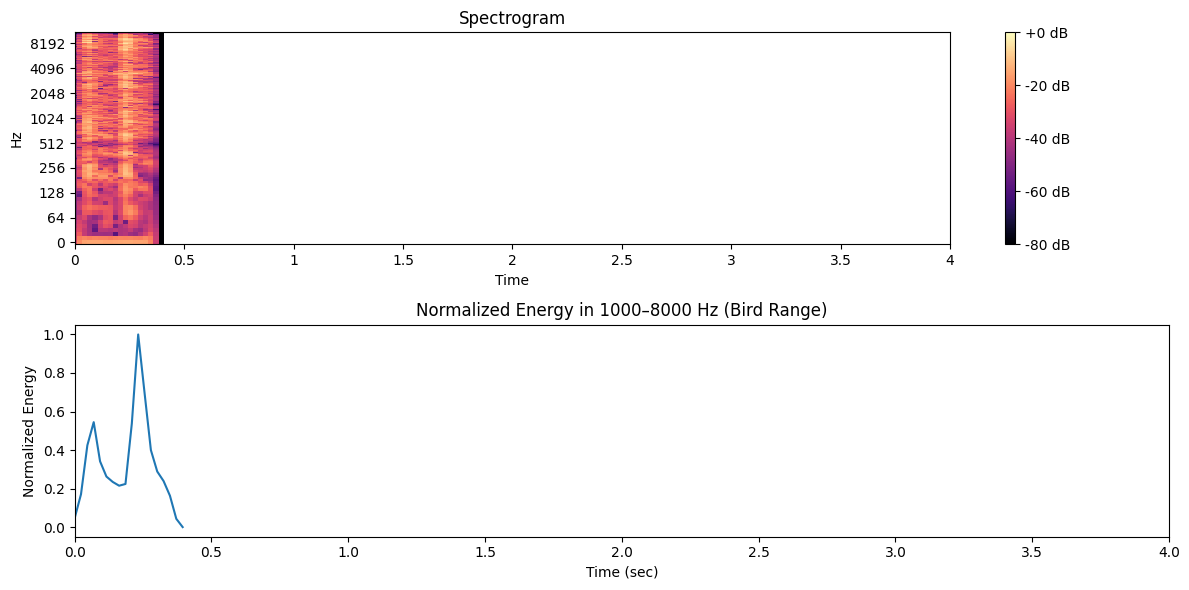

In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_and_energy(input_path, band=(1000, 8000), time_limit_sec=4):
    y, sr = librosa.load(input_path, sr=22050)
    hop_len = 512
    frame_len = 2048

    S = np.abs(librosa.stft(y, n_fft=frame_len, hop_length=hop_len))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_len)

    # Bird frequency band
    bird_mask = (freqs >= band[0]) & (freqs <= band[1])
    bird_energy = S[bird_mask].mean(axis=0)
    bird_energy /= bird_energy.max()

    # Compute frame range to match time_limit_sec
    max_frame = int((time_limit_sec * sr) / hop_len)
    bird_energy_zoom = bird_energy[:max_frame]

    plt.figure(figsize=(12, 6))

    # Spectrogram
    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             sr=sr, y_axis='log', x_axis='time', hop_length=hop_len)
    plt.xlim(0, time_limit_sec)
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    # Energy in bird band
    plt.subplot(2, 1, 2)
    times = np.arange(len(bird_energy_zoom)) * hop_len / sr
    plt.plot(times, bird_energy_zoom)
    plt.xlim(0, time_limit_sec)
    plt.title(f'Normalized Energy in {band[0]}–{band[1]} Hz (Bird Range)')
    plt.ylabel('Normalized Energy')
    plt.xlabel('Time (sec)')

    plt.tight_layout()
    plt.show()

# Example usage
plot_spectrogram_and_energy("C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed/21038/iNat65519_denoised_spectral.wav")


# Convert to NPY for CNN Ready

In [1]:
import os
import librosa
import numpy as np
from glob import glob
from joblib import Parallel, delayed
from tqdm import tqdm


base_folder = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"  # CHANGE THIS

n_jobs = -1  


def get_duration(file):
    try:
        y, sr = librosa.load(file, sr=None)
        return len(y) / sr
    except Exception as e:
        print(f"\n Error reading {file}: {e}")
        return None

# === Find all .wav files ===
wav_files = glob(os.path.join(base_folder, "**/*.wav"), recursive=True)
print(f"Found {len(wav_files)} files...\n")

# === Wrap with tqdm for parallel progress ===
durations = list(
    tqdm(
        Parallel(n_jobs=n_jobs)(delayed(get_duration)(f) for f in wav_files),
        total=len(wav_files),
        desc="Analyzing audio durations"
    )
)

# === Filter out failed files ===
durations = [d for d in durations if d is not None]


if durations:
    durations = np.array(durations)
    print("\n=== Audio Duration Stats ===")
    print(f" Shortest : {durations.min():.2f} seconds")
    print(f" Longest  : {durations.max():.2f} seconds")
    print(f" Average  : {durations.mean():.2f} seconds")
else:
    print(" No valid durations found.")

Found 142821 files...



Analyzing audio durations: 100%|██████████████████████████████████████████| 142821/142821 [00:00<00:00, 1505528.39it/s]


=== Audio Duration Stats ===
📏 Shortest : 0.05 seconds
📏 Longest  : 3.00 seconds
📏 Average  : 2.07 seconds


In [2]:
import os
import librosa
import numpy as np
from glob import glob
from PIL import Image
from joblib import Parallel, delayed
from tqdm import tqdm


input_base = "C:/Users/LENOVO/OneDrive - Binghamton University/Documents/00_BU/01 Spring 2025/Data Mining/Final Project/Bird_Audio_detection/preprocessed"
output_base = "C:/Users/LENOVO/Documents/00_BU/01 Spring 2025/Data Mining/mel_spectrograms"
target_size = (64, 128)  # (width, height) for PIL — this gives a 128x64 spectrogram
n_jobs = -1  


def process_audio(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=None)

        # Convert to Mel Spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Normalize and resize
        S_norm = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
        S_resized = Image.fromarray(np.uint8(S_norm * 255)).resize(target_size)
        S_array = np.array(S_resized)

        # Save .npy output
        rel_path = os.path.relpath(file_path, input_base)
        output_path = os.path.join(output_base, rel_path).replace('.wav', '.npy')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        np.save(output_path, S_array)

        return True
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return False

#  Find all .wav files 
wav_files = glob(os.path.join(input_base, '**/*.wav'), recursive=True)
print(f"Found {len(wav_files)} .wav files.\n")

#  Parallel Processing with Progress Bar 
results = list(
    tqdm(
        Parallel(n_jobs=n_jobs)(delayed(process_audio)(f) for f in wav_files),
        total=len(wav_files),
        desc="Processing Spectrograms"
    )
)


successes = sum(results)
print(f"\n Done! Successfully processed {successes}/{len(wav_files)} files.")


📁 Found 142821 .wav files.



🎧 Processing Spectrograms: 100%|█████████████████████████████████████████| 142821/142821 [00:00<00:00, 1227837.06it/s]


✅ Done! Successfully processed 142821/142821 files.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def npy_to_png(npy_path, output_path=None, cmap='magma'):
    try:
        # Load the .npy file
        spec = np.load(npy_path)

        # Plot the spectrogram
        plt.figure(figsize=(4, 4))
        plt.imshow(spec, aspect='auto', origin='lower', cmap=cmap)
        plt.axis('off')

        # Save to .png
        if output_path is None:
            output_path = npy_path.replace(".npy", ".png")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f" Saved PNG to {output_path}")
    except Exception as e:
        print(f" Failed to convert {npy_path} to PNG: {e}")


npy_file = "C:/Users/LENOVO/Documents/00_BU/01 Spring 2025/Data Mining/mel_spectrograms/1564122/CSA34200_denoised_hpss.npy"
npy_to_png(npy_file)


✅ Saved PNG to C:/Users/LENOVO/Documents/00_BU/01 Spring 2025/Data Mining/mel_spectrograms/1564122/CSA34200_denoised_hpss.png
